In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)


X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [10]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [11]:
y_predict = dt.predict(X_test)
tp = (
    (y_test == 1) & (y_test == y_predict)
).sum()  # 123
tn = (
    (y_test == 0) & (y_test == y_predict)
).sum()  # 199
fp = (
    (y_test == 0) & (y_test != y_predict)
).sum()  # 25
fn = (
    (y_test == 1) & (y_test != y_predict)
).sum()  # 46

In [12]:
from sklearn.metrics import confusion_matrix
y_predict = dt.predict(X_test)
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=[
        "Predict died",
        "Predict Survive",
    ],
    index=["True Death", "True Survive"],
)

,Predict died,Predict Survive
True Death,199,25
True Survive,48,121


/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


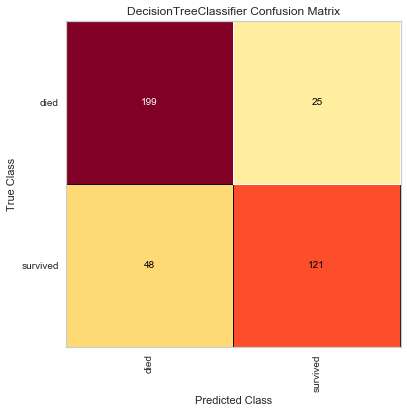

In [13]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    ConfusionMatrix,
)
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    dt,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()
#fig.savefig("images/mlpr_1202.png", dpi=300)

In [14]:
(tp + tn) / (tp + tn + fp + fn)

0.8142493638676844

In [15]:
from sklearn.metrics import accuracy_score
y_predict = dt.predict(X_test)
accuracy_score(y_test, y_predict)

0.8142493638676844

In [16]:
tp / (tp + fn)
from sklearn.metrics import recall_score
y_predict = dt.predict(X_test)
recall_score(y_test, y_predict)

0.7159763313609467

In [17]:
tp / (tp + fp)
from sklearn.metrics import precision_score
y_predict = dt.predict(X_test)
precision_score(y_test, y_predict)

0.8287671232876712

In [18]:
pre = tp / (tp + fp)
rec = tp / (tp + fn)
(2 * pre * rec) / (pre + rec)
from sklearn.metrics import f1_score
y_predict = dt.predict(X_test)
f1_score(y_test, y_predict)

0.7682539682539683

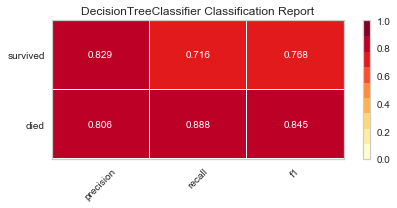

In [19]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    ClassificationReport,
)
fig, ax = plt.subplots(figsize=(6, 3))
cm_viz = ClassificationReport(
    dt,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()
#fig.savefig("images/mlpr_1203.png", dpi=300)

In [20]:
from sklearn.metrics import roc_auc_score
y_predict = dt.predict(X_test)
roc_auc_score(y_test, y_predict)

0.8021845942519018

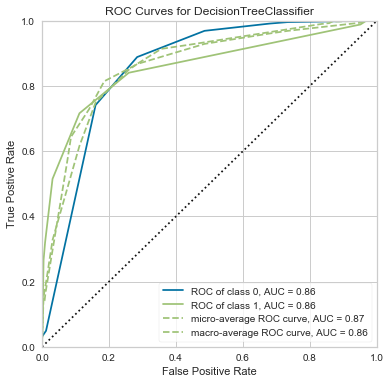

In [21]:
from yellowbrick.classifier import ROCAUC
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(dt)
roc_viz.score(X_test, y_test)
roc_viz.poof()
#fig.savefig("images/mlpr_1204.png", dpi=300)

In [22]:
from sklearn.metrics import (
    average_precision_score,
)
y_predict = dt.predict(X_test)
average_precision_score(y_test, y_predict)

0.7155150490642249

0.8177126373723864


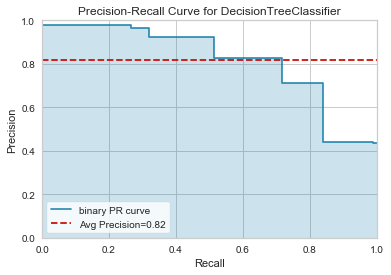

In [23]:
from yellowbrick.classifier import (
    PrecisionRecallCurve,
)
fig, ax = plt.subplots(figsize=(6, 4))
viz = PrecisionRecallCurve(
    DecisionTreeClassifier(max_depth=3)
)
viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.poof()
#fig.savefig("images/mlpr_1205.png", dpi=300)

/Users/matt/.env/364/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


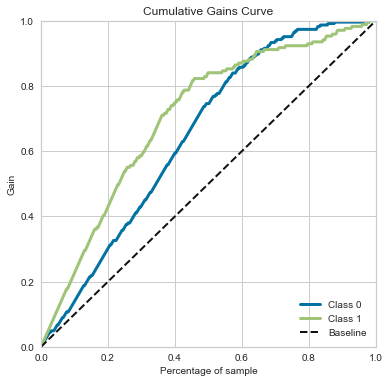

In [26]:
import scikitplot
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = dt.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(
    y_test, y_probas, ax=ax
)
# fig.savefig(
#     "images/mlpr_1206.png",
#     dpi=300,
#     bbox_inches="tight",
# )

/Users/matt/.env/364/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


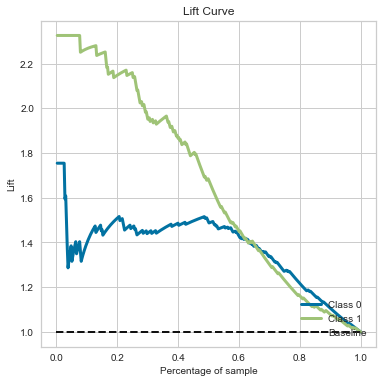

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = dt.predict_proba(X_test)
scikitplot.metrics.plot_lift_curve(
    y_test, y_probas, ax=ax
)
# fig.savefig(
#     "images/mlpr_1207.png",
#     dpi=300,
#     bbox_inches="tight",
# )

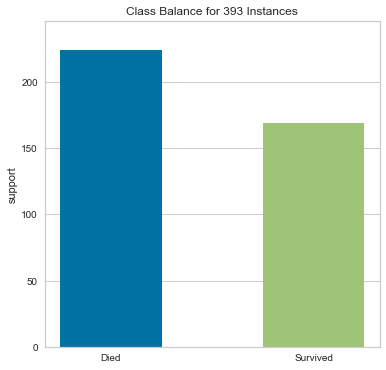

In [28]:
from yellowbrick.classifier import ClassBalance
fig, ax = plt.subplots(figsize=(6, 6))
cb_viz = ClassBalance(
    labels=["Died", "Survived"]
)
cb_viz.fit(y_test)
cb_viz.poof()
#fig.savefig("images/mlpr_1208.png", dpi=300)

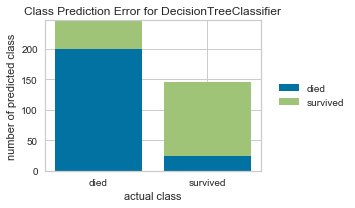

In [29]:
from yellowbrick.classifier import (
    ClassPredictionError,
)
fig, ax = plt.subplots(figsize=(6, 3))
cpe_viz = ClassPredictionError(
    dt, classes=["died", "survived"]
)
cpe_viz.score(X_test, y_test)
cpe_viz.poof()
#fig.savefig("images/mlpr_1209.png", dpi=300)

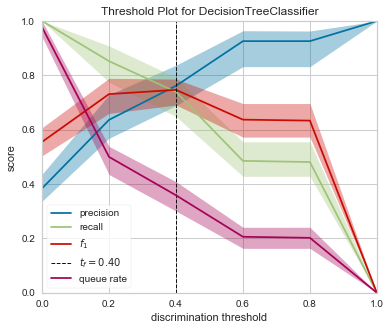

In [30]:
from yellowbrick.classifier import (
    DiscriminationThreshold,
)
fig, ax = plt.subplots(figsize=(6, 5))
dt_viz = DiscriminationThreshold(dt)
dt_viz.fit(X, y)
dt_viz.poof()
#fig.savefig("images/mlpr_1210.png", dpi=300)

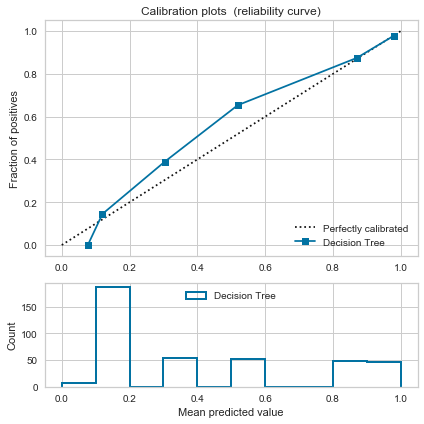

In [31]:
from sklearn.calibration import (
    calibration_curve,
)
def calib_plot(clf, name, X_test):
    fig = plt.figure(figsize=(6, 6))
    ax1 = plt.subplot2grid(
        (3, 1), (0, 0), rowspan=2
    )
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(
        [0, 1],
        [0, 1],
        "k:",
        label="Perfectly calibrated",
    )
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[
            :, 1
        ]
    else:  # use decision function
        prob_pos = clf.decision_function(
            X_test
        )
        prob_pos = (
            prob_pos - prob_pos.min()
        ) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_pos, n_bins=10
    )
    ax1.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label="%s" % (name,),
    )
    ax2.hist(
        prob_pos,
        range=(0, 1),
        bins=10,
        label=name,
        histtype="step",
        lw=2,
    )
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(
        "Calibration plots  (reliability curve)"
    )
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    plt.tight_layout()
    plt.show()
    return fig
fig = calib_plot(dt, "Decision Tree", X_test)
#fig.savefig("images/cp.png", dpi=300)